### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* 캐글데이터셋 : https://www.kaggle.com/c/dogs-vs-cats
* 내꺼 :https://www.kaggle.com/datasets/tongpython/cat-and-dog

{"username":"sangdal","key":"fce415bbfc97905e33c7e4a8ea3f20b6"}

In [1]:
# 캐글에서 바로 데이터셋 가져오기
import os

In [2]:
os.environ['KAGGLE_USERNAME'] ='sangdal' # username
os.environ['KAGGLE_KEY'] = 'fce415bbfc97905e33c7e4a8ea3f20b6' # key

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
#!kaggle competitions download -c dogs-vs-cats
!unzip -q cat-and-dog.zip

 96% 210M/218M [00:01<00:00, 139MB/s]
100% 218M/218M [00:01<00:00, 139MB/s]


#과제시작

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [5]:
# GPU사용하기
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
data_transforms = {
    'train' : transforms.Compose([                              # Compose 아래 내용을 한꺼번에 실행시켜라
        transforms.Resize((224,224)),                           # 224,224사이즈로 변경 하기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # 랜덤하게 10개를 뽑아서 규모는 +-20%
        transforms.RandomHorizontalFlip(),                      # 이미지 반전시킴
        transforms.ToTensor()                                   # 텐서 형태로 바꿔라
    ]),
    'test_set' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [7]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [8]:
# 데이터셋 만들기 'train' 'test_set'

image_datasets = {
    'train' : datasets.ImageFolder('training_set/training_set', data_transforms['train'], target_transform = target_transforms),
    'test_set' : datasets.ImageFolder('test_set/test_set', data_transforms['test_set'], target_transform = target_transforms)
}

dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'test_set' : DataLoader(
        image_datasets['test_set'],
        batch_size = 32,
        shuffle = False
    )
}

print(len(image_datasets['train']), len(image_datasets['test_set']))

8005 2023


In [ ]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(20,10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))
  ax.axis('off')

In [ ]:
# model = models.resnet50(pretrained =  True).to(device)
# pretrained =  True (전이학습을 하겠다.)
# pretrained =  False (전이학습을 하지 않겠다.)
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)
print(model)

In [ ]:
# 강아지랑 고양이랑 두가지뿐이 없기 때문에 해더 부분을 고쳐 줘야합니다.

for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

In [12]:
#'train' 'test_set'
# 학습: fc부분만 학습하므로 속도가 빠름

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 3

for epoch in range(epochs):
  for phase in ['train','test_set']:
    if phase == 'train':
      model.train() # 메모리에 옵티마이저가 돌아갈 메모리를 할당해준다.
    else:
      model.eval() # 옵티마이저 돌아갈 메모리를 지워버리고 테스트를 하기때문에 메모리가 절약되어 속도가빠름


    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])


    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/3, Loss: 0.1274, Accuracy: 94.48%
test_set  : Epoch    1/3, Loss: 0.0662, Accuracy: 97.36%
train     : Epoch    2/3, Loss: 0.0954, Accuracy: 96.29%
test_set  : Epoch    2/3, Loss: 0.0509, Accuracy: 98.49%
train     : Epoch    3/3, Loss: 0.0763, Accuracy: 97.04%
test_set  : Epoch    3/3, Loss: 0.0428, Accuracy: 98.68%


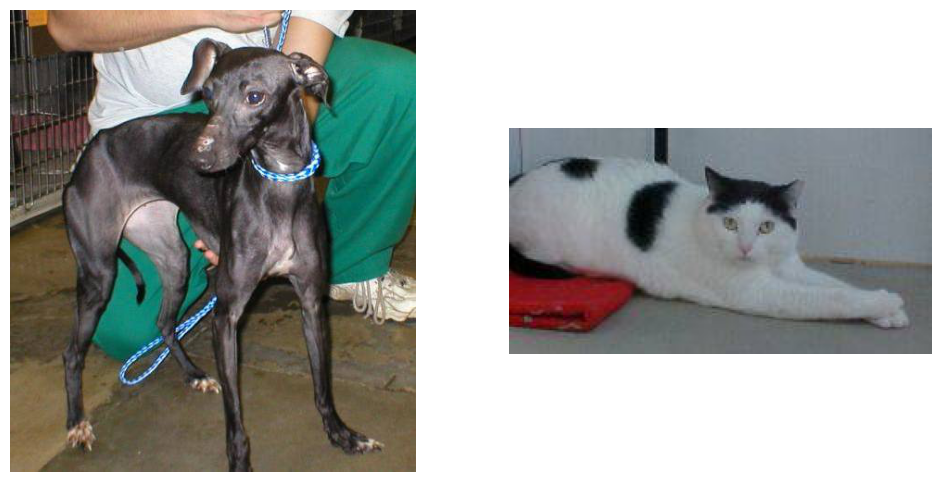

In [23]:
# 테스트 해보기
from PIL import Image

# 학습용(train)말고  validation안에 있는 이미지를 사용한다.
img1 = Image.open('/content/test_set/test_set/dogs/dog.4004.jpg')
img2 = Image.open('/content/test_set/test_set/cats/cat.4022.jpg')

# 어떤 사진인지 확인해보기(안해도 상관은 없음)
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [24]:
# 테스트를 위해 사이즈 변경하기
img1_input = data_transforms['test_set'](img1)
img2_input = data_transforms['test_set'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [25]:
# 이미지 두개 붙이기
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [26]:
# 예측해보기
y_pred = model(test_batch)
y_pred

tensor([[0.9975],
        [0.0091]], device='cuda:0', grad_fn=<SigmoidBackward0>)

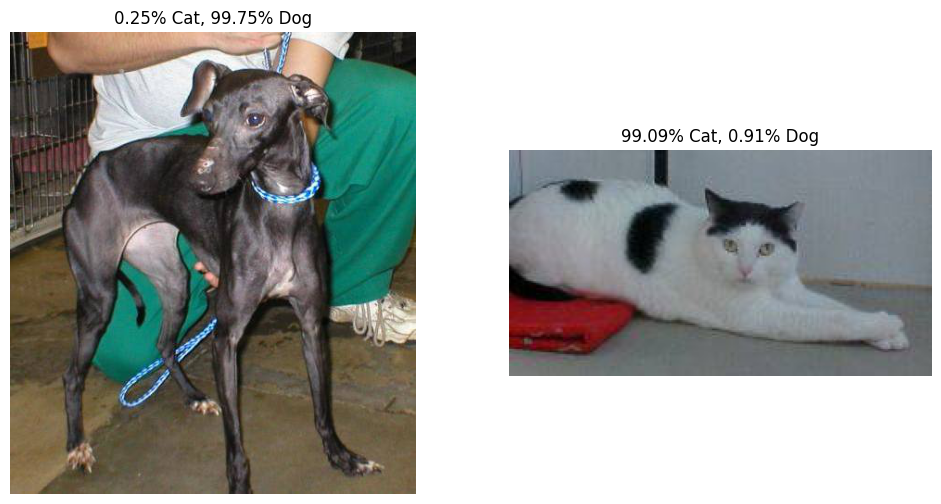

In [27]:
# 강아지, 고양이  사진 img1,img2 테스트 해보기
fig, axes = plt.subplots(1,2,figsize=(12,6))

axes[0].set_title(f'{(1-y_pred[0,0])*100:.2f}% Cat, {y_pred[0,0] * 100:.2f}% Dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0])*100:.2f}% Cat, {y_pred[1,0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()